In [41]:
# load libraries
import xgboost as xgb
import lightgbm as lgb
import missingno as msno
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

In [69]:
# set directory and load files
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'
train_path = join(data_dir, 'train.csv')
test_path = join(data_dir, 'test.csv')

data = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(data.shape)
print(test.shape)

(15035, 21)
(6468, 20)


In [30]:
# data and test info and any null vals
print(data.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

### Data Info

- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment,
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house‚Äôs last renovation
- zipcode - What zipcode area the house is in
- lat - Lattitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

1. ID : ÏßëÏùÑ Íµ¨Î∂ÑÌïòÎäî Î≤àÌò∏
2. date : ÏßëÏùÑ Íµ¨Îß§Ìïú ÎÇ†Ïßú
3. price : ÌÉÄÍ≤ü Î≥ÄÏàòÏù∏ ÏßëÏùò Í∞ÄÍ≤©
4. bedrooms : Ïπ®Ïã§Ïùò Ïàò
5. bathrooms : Ïπ®Ïã§Îãπ ÌôîÏû•Ïã§ Í∞úÏàò
6. sqft_living : Ï£ºÍ±∞ Í≥µÍ∞ÑÏùò ÌèâÎ∞© ÌîºÌä∏
7. sqft_lot : Î∂ÄÏßÄÏùò ÌèâÎ∞© ÌîºÌä∏
8. floors : ÏßëÏùò Ï∏µÏàò
9. waterfront : ÏßëÏùò Ï†ÑÎ∞©Ïóê Í∞ïÏù¥ ÌùêÎ•¥ÎäîÏßÄ Ïú†Î¨¥ (a.k.a. Î¶¨Î≤ÑÎ∑∞)
10. view : ÏßëÏù¥ ÏñºÎßàÎÇò Ï¢ãÏïÑ Î≥¥Ïù¥ÎäîÏßÄÏùò Ï†ïÎèÑ
11. condition : ÏßëÏùò Ï†ÑÎ∞òÏ†ÅÏù∏ ÏÉÅÌÉú
12. grade : King County grading ÏãúÏä§ÌÖú Í∏∞Ï§ÄÏúºÎ°ú Îß§Í∏¥ ÏßëÏùò Îì±Í∏â
13. sqft_above : ÏßÄÌïòÏã§ÏùÑ Ï†úÏô∏Ìïú ÌèâÎ∞© ÌîºÌä∏
14. sqft_basement : ÏßÄÌïòÏã§Ïùò ÌèâÎ∞© ÌîºÌä∏
15. yr_built : ÏßëÏùÑ ÏßÄÏùÄ ÎÖÑÎèÑ
16. yr_renovated : ÏßëÏùÑ Ïû¨Í±¥Ï∂ïÌïú ÎÖÑÎèÑ
17. zipcode : Ïö∞Ìé∏Î≤àÌò∏
18. lat : ÏúÑÎèÑ
19. long : Í≤ΩÎèÑ
20. sqft_living15 : Í∑ºÏ≤ò 15 Í∞ÄÍµ¨Ïùò Ï£ºÍ±∞ Í≥µÍ∞Ñ, ÌèâÎ∞© ÌîºÌä∏
21. sqft_lot15 : Í∑ºÏ≤ò 15Í∞ÄÍµ¨Ïùò Î∂ÄÏßÄ, ÌèâÎ∞© ÌîºÌä∏

In [31]:
data.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  15035.000000  1.503500e+04  15035.000000  15035.000000  15035.000000   
mean    7517.000000  5.406827e+05      3.369139      2.115065   2083.790223   
std     4340.374984  3.715247e+05      0.902721      0.767519    922.134087   
min        0.000000  7.800000e+04      0.000000      0.000000    290.000000   
25%     3758.500000  3.220000e+05      3.000000      1.750000   1430.000000   
50%     7517.000000  4.500000e+05      3.000000      2.250000   1910.000000   
75%    11275.500000  6.450000e+05      4.000000      2.500000   2560.000000   
max    15034.000000  7.700000e+06     10.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  1.503500e+04  15035.000000  15035.000000  15035.000000  15035.000000   
mean   1.529697e+04      1.498071      0.007117      0.234253      3.406651   
std    4.261282e+04      0.538522      0.084063      0.763376      0.646505   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.027500e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.620000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.069550e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  15035.000000  15035.000000   15035.000000  15035.000000  15035.000000   
mean       7.660725   1794.158164     289.632059   1971.100432     83.798936   
std        1.179803    831.738609     440.663284     29.407612    400.398498   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1570.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2230.000000     550.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4130.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  15035.000000  15035.000000  15035.000000   15035.000000   15035.000000  
mean   98078.031726     47.560721   -122.213677    1992.754772   12823.884935  
std       53.297815      0.138164      0.141294     691.456442   27736.259787  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.472700   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571900   -122.231000    1850.000000    7610.000000  
75%    98117.000000     47.678300   -122.126000    2360.000000   10076.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

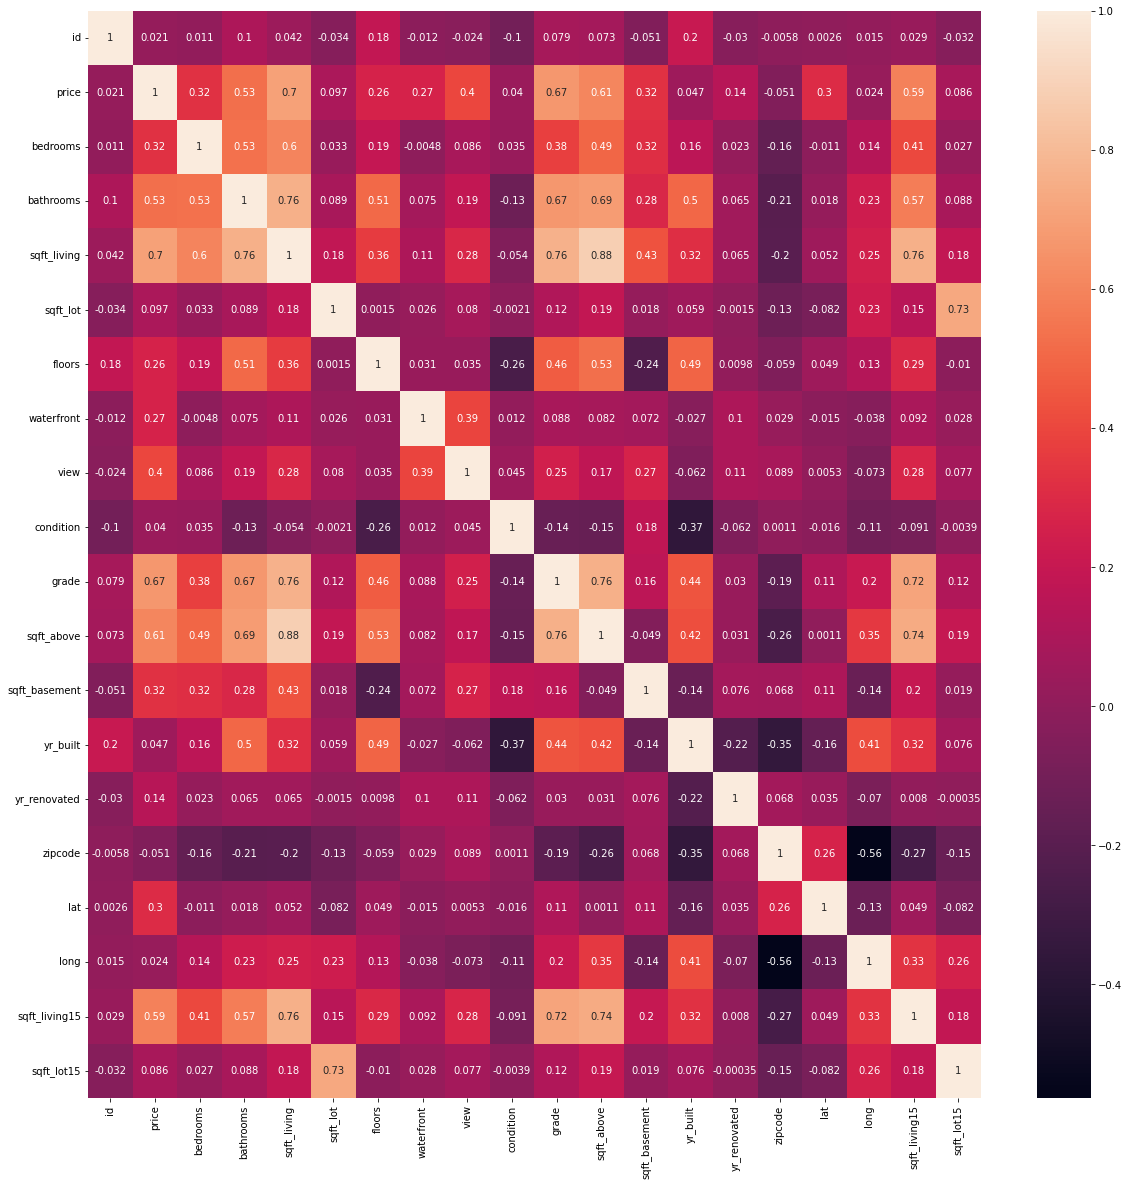

In [79]:
plt.figure(figsize=(20,20))
sns.heatmap(data=data.corr(), annot=True)
plt.show()

In [83]:
data['price'].max()

7700000.0

In [82]:
data[data['price'] == 770000]

id             date     price  bedrooms  bathrooms  sqft_living  \
196      196  20141113T000000  770000.0         4       2.75         3820   
2188    2188  20140522T000000  770000.0         4       2.50         2350   
2542    2542  20141219T000000  770000.0         3       2.75         2070   
2847    2847  20141001T000000  770000.0         3       1.75         1900   
4947    4947  20141002T000000  770000.0         7       2.25         3260   
5984    5984  20150508T000000  770000.0         4       3.00         2800   
6313    6313  20140512T000000  770000.0         3       1.75         1720   
6615    6615  20140717T000000  770000.0         5       1.50         2160   
7770    7770  20150212T000000  770000.0         4       1.75         2520   
8260    8260  20150218T000000  770000.0         3       3.50         2050   
8708    8708  20141030T000000  770000.0         4       2.50         3560   
8999    8999  20150108T000000  770000.0         3       2.50         2190   
9341    9341  20141120T000000  770000.0         4       2.25         2730   
10135  10135  20140904T000000  770000.0         3       2.50         2900   
10185  10185  20140922T000000  770000.0         3       3.25         3310   
10195  10195  20140603T000000  770000.0         3       2.50         2430   
11679  11679  20140717T000000  770000.0         3       2.50         3680   
11903  11903  20140618T000000  770000.0         4       2.50         3210   
12567  12567  20141119T000000  770000.0         3       1.00         2230   
12641  12641  20141029T000000  770000.0         5       3.00         2370   
12879  12879  20140925T000000  770000.0         4       3.50         3680   
12999  12999  20150316T000000  770000.0         4       1.00         1480   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
196       26300     2.0           0     0  ...      9        2850   
2188       8001     2.0           0     0  ...      8        2350   
2542      54557     2.0           0     0  ...      8        2070   
2847       6334     1.0           0     2  ...      8        1450   
4947       8145     2.0           0     0  ...      8        3260   
5984       9127     2.0           0     0  ...      9        2800   
6313       5000     1.0           0     0  ...      9        1720   
6615       5000     1.5           0     2  ...      8        2160   
7770       8442     1.0           0     0  ...      7        1640   
8260      21744     2.0           1     4  ...      9        1750   
8708       6187     2.0           0     0  ...      9        3560   
8999       2658     2.0           0     3  ...      9        2190   
9341       5000     1.0           0     0  ...      7        1460   
10135     23550     1.0           0     0  ...     10        1490   
10185      5000     2.0           0     0  ...      9        3310   
10195     54059     2.0           0     0  ...     10        2430   
11679     35617     1.0           0     0  ...     10        2390   
11903     14910     2.0           0     0  ...     10        3210   
12567      3200     2.0           0     2  ...      8        1630   
12641      6000     1.5           0     2  ...      8        1340   
12879      2242     2.5           0     0  ...      9        2670   
12999      3750     1.5           0     0  ...      7        1480   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
196              970      2014             0    98028  47.7618 -122.261   
2188               0      1987             0    98006  47.5478 -122.153   
2542               0      1996             0    98058  47.4659 -122.116   
2847             450      1948             0    98105  47.6675 -122.276   
4947               0      1967             0    98008  47.6336 -122.115   
5984               0      1999             0    98074  47.6123 -122.007   
6313               0      1954          2014    98122  47.6157 -122.290   
6615               0      1926             0    98

In [61]:
# assign price to a variable y and remove price column from data
# price is our target
y = data['price']
print(y.head())

data = data.drop(['price'], axis=1)
data.head()

0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64


id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

In [62]:
# concatenate two data sets to easily check any null vals and remove unnecessary columns
train_len = len(data)
data = pd.concat((data, test), axis=0)
print(train_len)
print(len(data))

15035
21503


<AxesSubplot:>

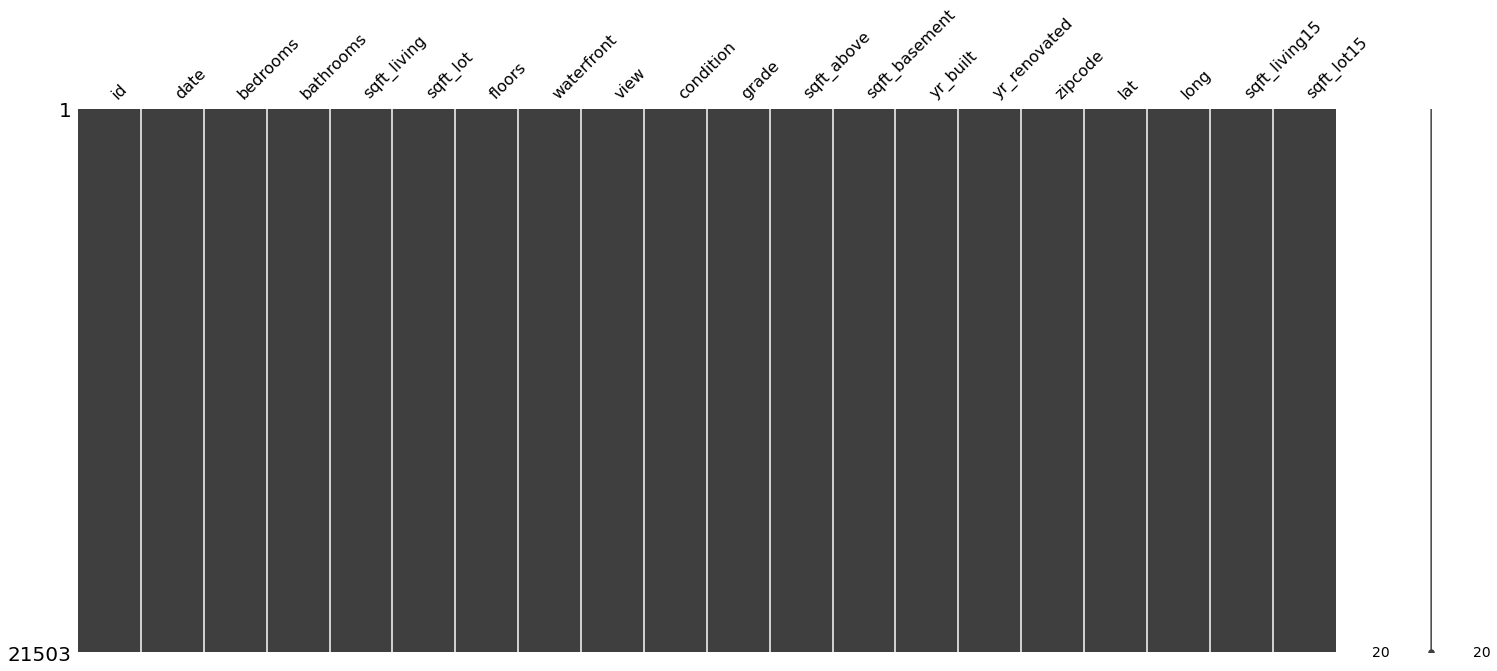

In [63]:
# using missingno matrix to check null vals
msno.matrix(data)

In [64]:
# another way to check any null vals
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [66]:
# need id for submission later, so assigning to a variable
sub_id = data['id'][train_len:]
del data['id']

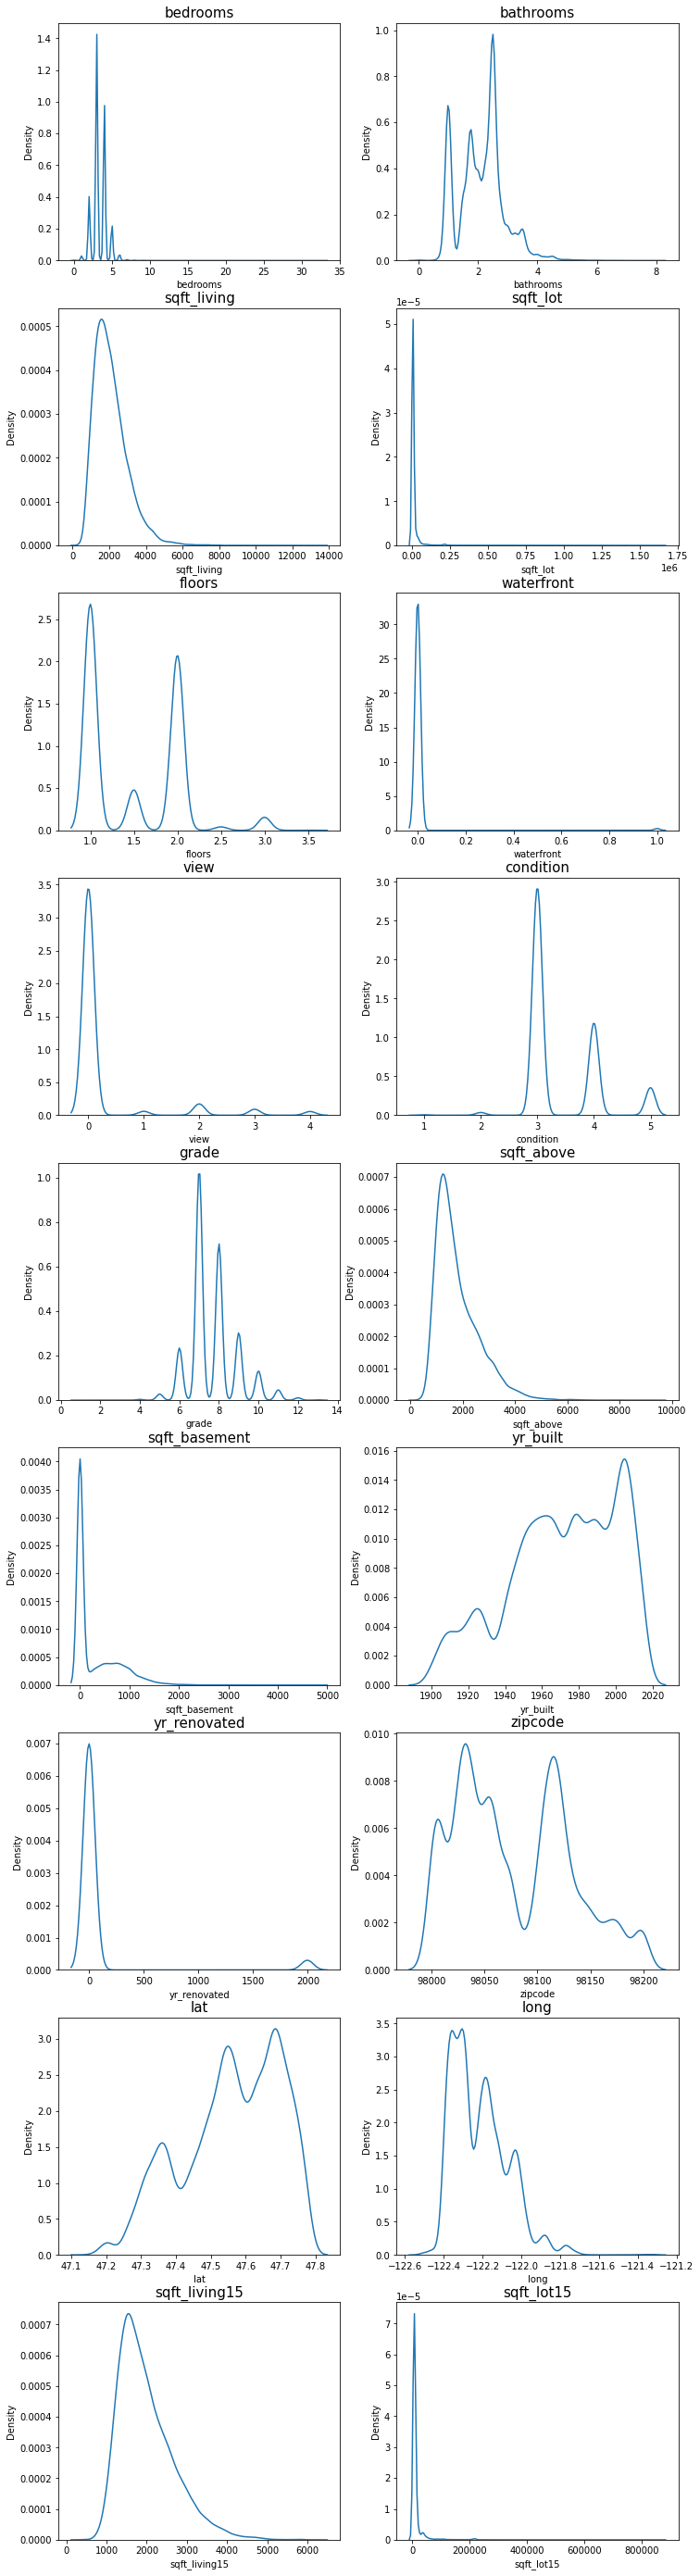

In [67]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id Î≥ÄÏàò(count==0Ïù∏ Í≤ΩÏö∞)Îäî Ï†úÏô∏ÌïòÍ≥† Î∂ÑÌè¨Î•º ÌôïÏù∏Ìï©ÎãàÎã§.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [ ]:
# removing date, lat, and long as we don't need these data
data = data.drop(['date', 'lat', 'long'], axis=1)
data.head()

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [ ]:
get_cv_score(models)

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('Ïñçüí¢')

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred